# Problema de Fluxo de Custo Mı́nimo (PFCM)

O **Problema de Fluxo de Custo Mínimo (PFCM)** é um dos modelos fundamentais da **Pesquisa Operacional** e da **Teoria dos Grafos**, sendo amplamente utilizado para otimizar o fluxo de recursos em redes. O objetivo é encontrar a maneira mais econômica de transportar um determinado recurso através de uma rede de nós e arestas, garantindo que todas as restrições de capacidade e demanda sejam atendidas.

In [12]:
import cplex
import networkx as nx
import matplotlib.pyplot as plt

## Leitura e pré-processamento dos dados

O PFCM é modelado como um **grafo dirigido** $G = (V, E)$, onde:  
- $V$ é o conjunto de **nós** (origens, destinos e intermediários).  
- $E$ é o conjunto de **arestas** (caminhos possíveis para o fluxo).  
- Cada nó $i$ tem um **balanço de fluxo $b_i$**, que pode representar:  
  - **Oferta** ($b_i > 0$): O nó fornece unidades do recurso.  
  - **Demanda** ($b_i < 0$): O nó precisa receber unidades.  
  - **Intermediário** ($b_i = 0$): O nó apenas transmite o fluxo.  
- Cada aresta $(i, j)$ tem:  
  - **Capacidade $u_{ij}$**: Limite máximo de fluxo permitido.  
  - **Custo $c_{ij}$**: Custo unitário para transportar o recurso pela aresta.  
  - **Variável de decisão $x_{ij}$**: Quantidade de fluxo enviada de $i$ para $j$. 

In [13]:
file = "in_pfcm.txt"

supply_demand = []
infinito = 1e20

with open(file, 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = list(filter(None, lines))

num_nodes, num_edges = map(int, lines[0].strip().split())

for line in lines[1:num_nodes + 1]:
    node_id, value = map(int, line.strip().split())
    supply_demand.append(value)

arcs = {}
for line in lines[num_nodes + 1:]:
    parts = line.strip().split()
    node1, node2, cost, min = map(int, parts[:4])
    max = int(parts[4]) if len(parts) > 4 else infinito
    arcs[(node1, node2)] = (cost, min, max)

print(supply_demand)
arcs

[10, 10, 10, 0, 0, -8, -7, -6, -9]


{(0, 5): (7, 0, 1e+20),
 (0, 3): (2, 0, 8),
 (1, 3): (5, 0, 7),
 (1, 2): (2, 0, 1e+20),
 (2, 3): (6, 0, 1e+20),
 (2, 4): (5, 0, 9),
 (2, 8): (4, 0, 6),
 (3, 5): (1, 0, 17),
 (3, 6): (3, 0, 4),
 (3, 7): (4, 0, 1e+20),
 (4, 8): (3, 0, 1e+20),
 (5, 6): (1, 0, 10),
 (6, 7): (1, 0, 1e+20),
 (7, 4): (2, 0, 1e+20)}

## Visualização do problema

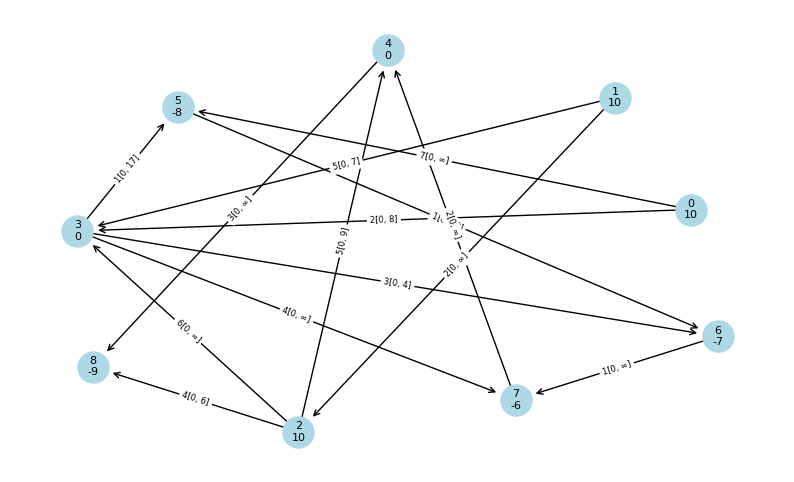

In [14]:
G = nx.DiGraph()

for i, oferta_demanda in enumerate(supply_demand):
    G.add_node(i, oferta_demanda=oferta_demanda)

for (u, v), (cost, min, max) in arcs.items():
    G.add_edge(u, v, cost=cost, min=min, max=max)

pos = nx.spring_layout(G, k=5.0, iterations=50)

node_labels = {i: f'{i}\n{G.nodes[i]["oferta_demanda"]}' for i in G.nodes}
edge_labels = {
    (u, v): f'{G[u][v]["cost"]}[{G[u][v]["min"]}, {G[u][v]["max"]}]' if G[u][v]["max"] != infinito
    else f'{G[u][v]["cost"]}[{G[u][v]["min"]}, ∞]' for u, v in G.edges
    }

plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, min_target_margin = 15)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.axis('off')
plt.show()

## Modelagem e solução

O objetivo é **minimizar o custo total de transporte**, dado por:

$\min \sum_{(i,j) \in E} c_{ij} \cdot x_{ij}$

Sujeito às restrições:  

1. **Restrição de capacidade**: O fluxo em uma aresta não pode exceder sua capacidade máxima:  
$0 \leq x_{ij} \leq u_{ij}, \quad \forall (i,j) \in E$

2. **Conservação de fluxo**: O fluxo que entra e sai de cada nó deve respeitar seu balanço $b_i$:  
$\sum_{j \in V} x_{ji} - \sum_{j \in V} x_{ij} = b_i, \quad \forall i \in V$

3. **Não negatividade**: Nenhum fluxo pode ser negativo:  
$x_{ij} \geq 0, \quad \forall (i,j) \in E$

In [15]:
infinito = 1e20
nodes = list(range(num_nodes))

model = cplex.Cplex()
model.set_problem_type(cplex.Cplex.problem_type.LP)
model.objective.set_sense(model.objective.sense.minimize)

# Variáveis de decisão
variaveis = []
objetivo = []
fluxo_minimo = []
fluxo_maximo = []

for (i, j), (cost, min, max) in arcs.items():
    variaveis.append(f"x{i}{j}")
    objetivo.append(cost)
    fluxo_minimo.append(min)
    fluxo_maximo.append(max)

model.variables.add(names=variaveis, obj=objetivo, lb=fluxo_minimo, ub=fluxo_maximo)

# Restrições de balanço de fluxo
for node in nodes:
    inflow = [f"x{i}{node}" for (i, j) in arcs.keys() if j == node]
    outflow = [f"x{node}{j}" for (i, j) in arcs.keys() if i == node]
    flow_vars = inflow + outflow
    coefficients = [-1] * len(inflow) + [1] * len(outflow)
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=flow_vars, val=coefficients)],
        senses=["E"], # Igualdade
        rhs=[supply_demand[node]]
    )

%time model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 1 columns.
Aggregator did 3 substitutions.
Reduced LP has 6 rows, 10 columns, and 20 nonzeros.
Presolve time = 0.01 sec. (0.01 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =           139.000000
CPU times: user 24.9 ms, sys: 3.04 ms, total: 28 ms
Wall time: 25.6 ms


## Sumário dos resultados

In [16]:
status = model.solution.get_status()
if status == model.solution.status.optimal:
    print("Status da solução:", model.solution.get_status_string())
    print(f"Custo total: {model.solution.get_objective_value()}")

    for var in variaveis:
        value = model.solution.get_values(var)
        if value > 0:
            print(f"{var}: {value}")

    model.write("./output/model_pfcm.lp")
    model.solution.write("./output/solution_pfcm.sol")
else:
    print("No Solution.")

Default row names c1, c2 ... being created.


Status da solução: optimal
Custo total: 184.0
x05: 2.0
x03: 8.0
x13: 7.0
x12: 3.0
x23: 4.0
x24: 3.0
x28: 6.0
x35: 16.0
x36: 3.0
x48: 3.0
x56: 10.0
x67: 6.0
